# Heart Disease Risk Analysis

## Introduction to the data

The data came from a kaggle data set (https://www.kaggle.com/rashikrahmanpritom/heart-attack-analysis-prediction-dataset) and contains features related to predicting heart attacks. The following are the features. There are 303 observations and 14 features.

age:  age of the patient

sex:  sex of the patient (1 = male; 0 = female)

exng: exercise induced angina (1 = yes; 0 = no)

cas: number of major vessels colorized by flourosopy (0-3)

cp: chest Pain type 
1. : typical angina
2. : atypical angina
3. : non-anginal pain
4. : asymptomatic

trtbps: resting blood pressure (in mm Hg) on admission

chol: cholestoral in mg/dl

fbs: fasting blood sugar > 120 mg/dl (1 = true; 0 = false)

rest_ecg : resting electrocardiographic results
1. 0 = normal
2. 1 = having ST-T wave abnormality
3. 3 = showing probable or definite left ventricular hypertrophy

thalachh: maximum heart rate achieved

oldpeak: ST depression induced by exercise relative to resting

slp: slope of the peak exercise ST segment (2 = upsloping; 1 = flat; 0 = downsloping)

thal: Thalium stress test result (1 = fixed defect; 2 = normal; 3 = reversible defect)

risk: risk of heart attack (0 = less chance of heart attack; 1 = high chance of heart attack)

****************

The **target feature** is **risk**. Therefore, we are attempting to classifiy observations based on whether they are likely to have heart attacks or not.

Let us load the data at observe them.

In [119]:
import pandas as pd
import numpy as np

data = pd.read_csv('heart.csv')
data.dtypes

age           int64
sex           int64
cp            int64
trtbps        int64
chol          int64
fbs           int64
restecg       int64
thalachh      int64
exng          int64
oldpeak     float64
slp           int64
caa           int64
thall         int64
risk          int64
dtype: object


It is clear that all the data have been coded properly and there are no missing values. Therefore, data does not need to be cleaned.

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.2)

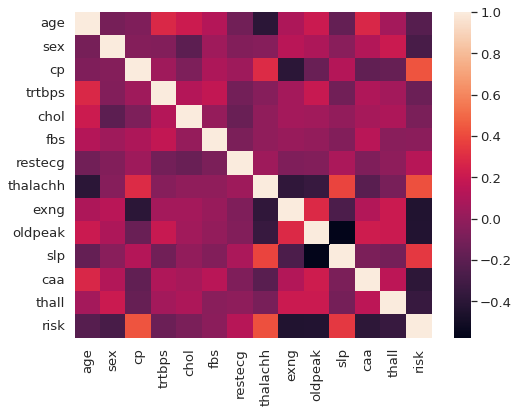

In [121]:
plt.figure(figsize=(8,6))
sns.heatmap(data.corr());


We can see that **risk** is highly correlated with variables *slp*, *thalachh*, and *cp*. There are also negative correlations with some variables.

### Data splitting

In this section, we will split our target and features as well as training and testing sets.

In [122]:
from sklearn.model_selection import StratifiedShuffleSplit

# Indexes to split.
sssplit = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=22)

features = data.columns[:-1]

train_idx, test_idx = next(sssplit.split(data[features], data.risk))

# Split data.
xtrain = data.loc[train_idx, features]
ytrain = data.loc[train_idx, 'risk']

xtest  = data.loc[test_idx, features]
ytest  = data.loc[test_idx, 'risk']

## Objectives

The objectives of this project are as follows.

1. Develop three classification models for the data.
2. Assess the quality of the models.
3. Make suggestions regarding improving the models.

## Classification models

### Logistic regression model

The first model is a logistic classifier. Let us use a grid search with cross validation to look for the best value for the hyper parameter *C*.


In [123]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

param_grid = {'C' : np.geomspace(0.001, 10, 20)}

lrgs = GridSearchCV(LogisticRegression(max_iter=10000, random_state=22), 
                    param_grid, cv = 4, 
                    scoring = 'accuracy', n_jobs = 2)

# Run the fit on the entire data frame.
lrgs.fit(data[features], data.risk)

# Best value for C
lrgs.best_params_['C']

0.5455594781168515


The best value for *C* is 0.55. We shall now fit our train and test data to calculate the error metrics.

In [124]:
lr = LogisticRegression(C=0.55, max_iter=10000)
lr = lr.fit(xtrain, ytrain)

ypred = lr.predict(xtest)


Let us now get the error metrics about above model.

In [125]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc

# For collecting various matrices of all models.
met = list()
cm = dict()

precision, recall, fscore, _ = score(ytest, ypred, average='weighted')
accuracy = accuracy_score(ytest, ypred)
confusion_mat = confusion_matrix(ytest, ypred)

a, b, _ = roc_curve(ytest, ypred)
rocauc = auc(a, b)

cm['LR'] = confusion_mat
met.append(pd.Series({'precision': precision, 'recall': recall, 'fscore': fscore, 
                      'accuracy': accuracy, 'roc_auc': rocauc}, name = 'Logistic Regression'))

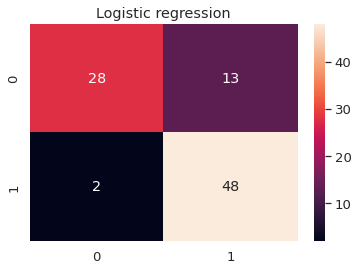

In [126]:
ax = plt.axes()
sns.heatmap(cm['LR'], annot=True)
ax.set_title('Logistic regression');

### Decision tree model

Let us now build a decision tree model and find the best values for *max_features* and *max_depth* hyper parameters using a grid search with cross validation.



In [127]:
from sklearn.tree import DecisionTreeClassifier

param_grid = {'max_depth': range(1, 20, 2),
              'max_features': range(1, 14)}

dtgs = GridSearchCV(DecisionTreeClassifier(random_state=22), 
                    param_grid=param_grid, 
                    scoring='accuracy', n_jobs=2)

# Run the fit on the entire data frame.
dtgs.fit(data[features], data.risk)

# Best values for hyper parameters.
dtgs.best_params_

{'max_depth': 3, 'max_features': 10}

Therefore, the best values for hyper parameters *max_depth* and *max_features* are 3 and 10 respectively.

Let us now fit our train data and test data to calculate metrics.

In [128]:
dt = DecisionTreeClassifier(max_depth=3, max_features=10, random_state=22)

dt = dt.fit(xtrain, ytrain)
ypred = dt.predict(xtest)

precision, recall, fscore, _ = score(ytest, ypred, average='weighted')
accuracy = accuracy_score(ytest, ypred)
confusion_mat = confusion_matrix(ytest, ypred)

a, b, _ = roc_curve(ytest, ypred)
rocauc = auc(a, b)

cm['DT'] = confusion_mat
met.append(pd.Series({'precision': precision, 'recall': recall, 'fscore': fscore, 
                      'accuracy': accuracy, 'roc_auc': rocauc}, name = 'Decision Tree'))


A peak into the confusion matrix.

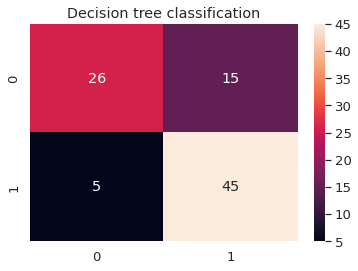

In [129]:
ax = plt.axes()
sns.heatmap(cm['DT'], annot=True)
ax.set_title('Decision tree classification');

### Ensemble method: random forest

We will now try a random forest method which is an ensemble method.

In [130]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': range(50, 550, 25)}

rfgs = GridSearchCV(RandomForestClassifier(oob_score=True, random_state=22, warm_start=True), 
                    param_grid=param_grid, n_jobs=2)

# Run the fit on the entire data frame.
rfgs.fit(data[features], data.risk)

# Best value for C
rfgs.best_params_

{'n_estimators': 225}

The best values for hyper parameter *n_estimators* is 225. 

Calculate error metrics are calculated below.

In [131]:
rf = RandomForestClassifier(n_estimators=225, oob_score=True, 
                            warm_start=True, random_state=22)

rf = rf.fit(xtrain, ytrain)
ypred = rf.predict(xtest)

precision, recall, fscore, _ = score(ytest, ypred, average='weighted')
accuracy = accuracy_score(ytest, ypred)
confusion_mat = confusion_matrix(ytest, ypred)

a, b, _ = roc_curve(ytest, ypred)
rocauc = auc(a, b)

cm['RF'] = confusion_mat
met.append(pd.Series({'precision': precision, 'recall': recall, 'fscore': fscore, 
                      'accuracy': accuracy, 'roc_auc': rocauc}, name = 'Random Forest'))

Let us observe the confusion matrix.

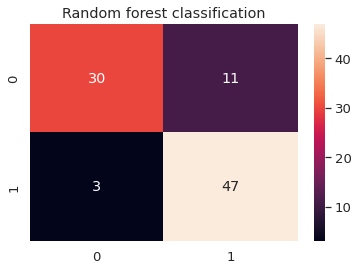

In [132]:
ax = plt.axes()
sns.heatmap(cm['RF'], annot=True)
ax.set_title('Random forest classification');

### Comparison of the models

Following table gives the comparison of the four metrics for three models developed above.

In [134]:
round(pd.DataFrame(met).T, 2)

,Logistic Regression,Decision Tree,Random Forest
precision,0.85,0.79,0.85
recall,0.84,0.78,0.85
fscore,0.83,0.77,0.84
accuracy,0.84,0.78,0.85
roc_auc,0.82,0.77,0.84



Let us now look at the feature importance for binary classification as predicted by the random forest model.

In [152]:
fimp = pd.DataFrame(zip(list(rf.feature_importances_), data[features]))
fimp.sort_values(by=0, ascending=False)

,0,1
2,0.149725,cp
9,0.128635,oldpeak
7,0.113410,thalachh
12,0.096066,thall
11,0.087117,caa
4,0.086160,chol
0,0.080104,age
3,0.073287,trtbps
8,0.070868,exng
10,0.055579,slp


## Key findings

1. With respect to almost all the metrics, the random forest has better performance than the other two.
2. The decision tree model is the worst model.
3. With regards to the roc_auc values, all three models are capables of correctly classifying because they all have ROC curves to the right of the diagonal.
4. According to the feature importance table, the most important predictor is *cp* i.e. chest pain type. This is followed by the *oldpeak*, a particular feature in an ECG report.
5. According to this analysis, *sex* of a person is not a stronger predictor when classifying whether a person is at risk of a heart attack or not.


## Suggestions

1. Ensemble model's grid search can be improved by introducing more parameters to the param_grid. For example, *max_depth*. I was unable to do this because the execution time was prohibitively high.

2. The number of data points i.e. observations in the data set is not enough for the analysis. A larger data set would be better.
